# Objective

The objective of this notebook is to visualize the bell-shape response of trimer concentration as a function of a bispecific antibody concentration.

In [7]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings

default(; # Plots defaults
    fontfamily="Computer modern"
    )

# Three-body model

Drug concentration in the tme is $B$, CD3 target is $T_1$ and Pcad concentration is $T_2$. No internalization or drug degradation.


\begin{align}
        \dot{B} &  = - k_{n1} T_1 B - k_{n2} T_2 B + k_{f1} D_1 + k_{f2} D_2,\\
        \dot{T_1} & = - k_{n1} T_1 B + k_{f1} D_1 - k_{n1} T_1 D_2 + k_{f1} Y,\\
        \dot{T_2} & = - k_{n2} T_2 B + k_{f2} D_2 - k_{n2} T_2 D_1 + k_{f2} Y,\\
        \dot{D_1} & = k_{n1} T_1 B - k_{f1} D_1 - k_{n2} T_2 D_1 + k_{f2} Y,\\
        \dot{D_2} & = k_{n2} T_2 B + k_{f2} D_2 - k_{n1} T_1 D_2 + k_{f1} Y,\\
        \dot{Y} & = k_{n1} T_1 D_2 + k_{n2} T_2 D_1 - (k_{f1}+k_{f2}) Y.
\end{align}


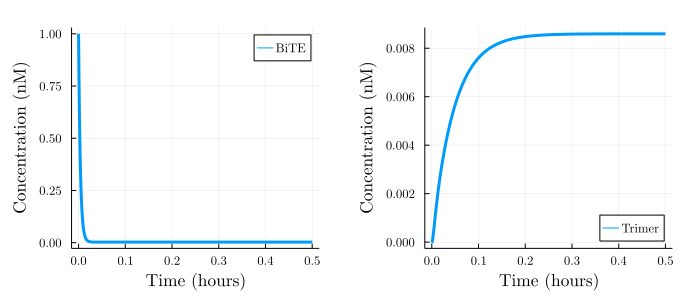

In [8]:
function threebody(du,u,p,t)
    B, T₁, T₂, D₁, D₂, Y = u
    kn₁, kf₁, kn₂, kf₂ = p 
    du[1]= -kn₁*T₁*B +kf₁*D₁ -kn₂*T₂*B  +kf₂*D₂
    du[2]= -kn₁*T₁*B +kf₁*D₁ -kn₁*T₁*D₂ +kf₁*Y
    du[3]= -kn₂*T₂*B +kf₂*D₂ -kn₂*T₂*D₁ +kf₂*Y
    du[4]= +kn₁*T₁*B -kf₁*D₁ -kn₂*T₂*D₁ +kf₂*Y
    du[5]= +kn₂*T₂*B -kf₂*D₂ -kn₁*T₁*D₂ +kf₁*Y
    du[6]= +kn₁*T₁*D₂ +kn₂*T₂*D₁ -(kf₁+kf₂)*Y
end

x0 = [1e0,1.08e-1,166,0.0,0.0,0.0]
ts = (0.0,0.5)
p  = [1.72,19.66,1.57,0.74]
problemo = ODEProblem(threebody,x0,ts,p)
solution = solve(problemo, abstol=1e-18, reltol=1e-18)

p1 = plot(solution.t,solution[1,:],linewidth=3,label="BiTE",
         ylabel="Concentration (nM)", xlabel="Time (hours)")
p2 = plot(solution.t,solution[6,:],linewidth=3,label="Trimer",
         ylabel="Concentration (nM)", xlabel="Time (hours)", legend=:bottomright)
p  = plot(p1,p2, layout=(1,2), size=(700,300), margin=5mm)

# Bell-shape

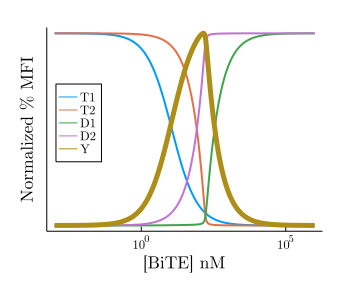

In [9]:
# find steady states at a given dose
function simulate(problem, dose)
    ss = zeros(length(dose),6)
    pp = remake(problem; tspan=(0.0,1e3))
    for index=1:length(dose) 
        problem_ = remake(pp, u0=vcat(dose[index], pp.u0[2:end]))
        solution = solve(problem_)
        ss[index,:] = solution[:,end]'
    end
    return ss
end

# visualize in maximum fluorescent intensity format
function mfi(problem,l,b, name)
    dose = 10 .^(range(l,b,length=1000)) # change l and b customize x axis
    m = simulate(problem, dose)
    p = plot(size=(350,300), margin=5mm) 
    p = plot!(p, dose, m[:,2]./maximum(m[:,2]), label="T1", xaxis=:log,
        linewidth=2, ylabel="Normalized % MFI", xlabel="[BiTE] nM",
        legend=:left, grid=:off, yaxis=nothing)
    p = plot!(p,dose, m[:,3]./maximum(m[:,3]), label="T2", linewidth=2)
    p = plot!(p,dose, m[:,4]./maximum(m[:,4]), label="D1", linewidth=2)
    p = plot!(p,dose, m[:,5]./maximum(m[:,5]), label="D2", linewidth=2)
    p = plot!(p,dose, m[:,6]./maximum(m[:,6]), label="Y", linewidth=5)
    savefig(p, "figures/"*name*".png")
    savefig(p, "figures/"*name*".pdf")
    display(p)
end

mfi(problemo,-3,6, "bell-shape")

# Adjourn

In [10]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")

mahdiar


"2022/February/28 14:08"